# Guidelines

This task tests your ability to apply Recommendation Engine concepts and techniques to a real-world Movie Recommender System.



Task: Build a Movie Recommender system with the following methods:

## -Popularity,

## -Content Filter,

## -Collaborative Filter,

## -Matrix Factorization



Also, try the following libraries on the dataset:

## Turicreate

## Surprise


Dataset: MovieLens 20M 

Source: https://grouplens.org/datasets/movielens/20m/



Hints:

1. Read Movies.csv, Ratings.csv and Tags.csv. No need for genome-scores.csv, genome-tags.csv

2. Create content filtering method on metadata obtained from merging movies and tags

3. Metadata should be formed from joining all tag field for each movie_title.

4. Build a Tfidf Vectorizer model and TruncatedSVD for Content filter - Latent matrix 1 on this data

5. Create a Collab filter on User Movie matrix (formed from pivot table on ratings data)

6. Create a Latent matrix 2 on this data

7. Code hybrid model



Open a fresh notebook(.ipynb) and Name it as with the following convention:

If your name is Vejey Gandyer, your filename for ipynb should be "Vejey_Task3_Movie_Recommenders.ipynb".



Start creating cells and put the logic as and when required. 



Save the notebook and Submit the notebook (.ipynb).





Note: Use GPU for this task. It will take days to compute in CPU :)



Try using Kaggle Kernel, Google Colab or Your OWN local GPU machine.





Have fun learning. All the very best.

## Downloading packages

In [2]:
#!pip install surprise

  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
  Using cached scikit_surprise-1.1.1-cp38-cp38-win_amd64.whl


In [2]:
#!pip install scikit-surprise

  Using cached scikit_surprise-1.1.1-cp38-cp38-win_amd64.whl


## importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from surprise import Dataset, Reader, accuracy, SVD
from surprise.model_selection import train_test_split
import sys

## Importing datasets

In [2]:
movies=pd.read_csv('movies.csv')
ratings =pd.read_csv('ratings.csv')
tags=pd.read_csv('tags.csv')

# Preparing datasets
I coded this notebook entirely using CPU, whitout GPU. In order to do that I've applied a filter on the data so that I keep in the dataset only the users with at least 250 movie ratings. This keeps 93 of the movies but uses only 15.6% of the users. This makes the dataset way less big and also, doesnt compromose the accuracy.

In [3]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


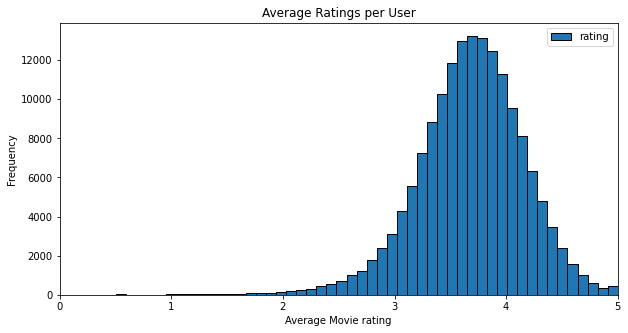

In [6]:
histogram = ratings[['userId','rating']].groupby('userId').mean()
histogram.plot(kind='hist', bins=50, grid=0, edgecolor='black', figsize=(10,5))
plt.xlim(0,5)
plt.legend()
plt.xlabel ('Average Movie rating')
plt.ylabel ('Frequency')
plt.title ('Average Ratings per User')
plt.show()

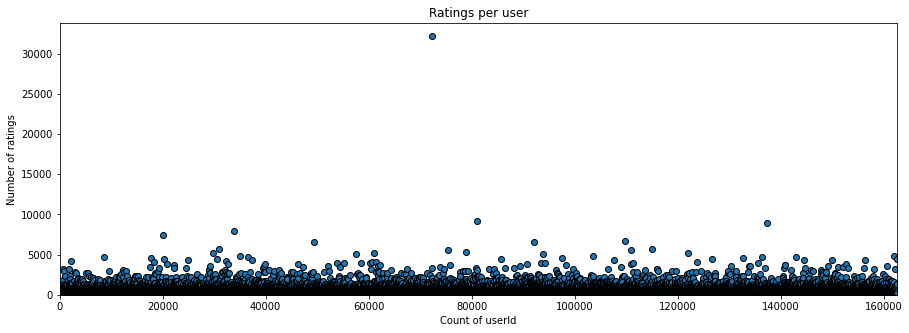

In [7]:
# Scatter plot of all users and individual ratings count.
plots = ratings[['userId', 'movieId']].groupby('userId').count()
plots.columns=['ratings']
plt.figure(figsize=(15,5))
plt.scatter(plots.index, plots.ratings, edgecolor='black')
plt.xlim(0,len(plots.index))
plt.ylim(0,)
plt.title('Ratings per user')
plt.xlabel('Count of userId')
plt.ylabel('Number of ratings')
plt.show()


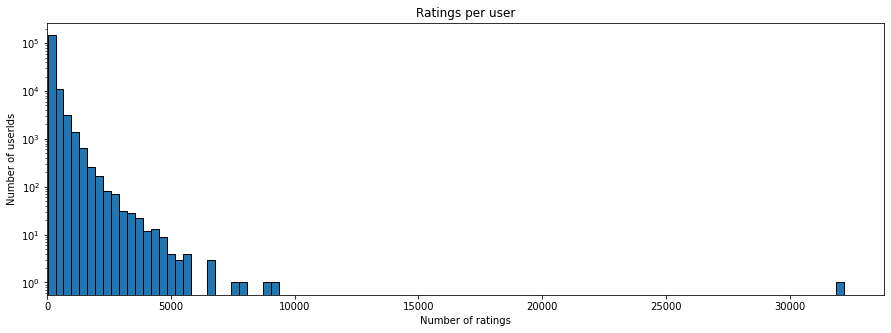

In [8]:
# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(plots.ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per user')
plt.xlabel('Number of ratings')
plt.ylabel('Number of userIds')
plt.xlim(0,)
#plt.xticks(np.arange(0,10000,500))
plt.show()

##filters the number of movies we can keep-- the reason is my laptop limited power.

In [9]:
    # filters the number of movies we can keep-- the reason is my laptop limited power.
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 250)
movie_list_rating = ratings_f.movieId.unique().tolist()

print('This code keeps',round(len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100,2),'%','of the original movie titles, using only ',
      round(len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100,2),'%',
      'of the users. This allows me to get a very good accuracy without compromise performance')

This code keeps 93.42 % of the original movie titles, using only  15.68 % of the users. This allows me to get a very good accuracy without compromise performance


In [92]:
# filter the movies data frame
movies = movies[movies.movieId.isin(movie_list_rating)]

In [93]:
# map movie to id:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [94]:
# remove unnecessary timesteps
tags.drop(['timestamp'], 1, inplace=True)
ratings_f.drop(['timestamp'], 1, inplace=True)

C:\Users\eduar\AppData\Local\Temp/ipykernel_48620/250184249.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  tags.drop(['timestamp'], 1, inplace=True)
C:\Users\eduar\AppData\Local\Temp/ipykernel_48620/250184249.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ratings_f.drop(['timestamp'], 1, inplace=True)


In [95]:
# make a useful dataframe from tags and movies
mixed = pd.merge(movies, tags, on='movieId', how='left')

##Create content filtering method on metadata obtained from merging movies and tags. 
Metadata should be formed from joining all tag field for each movie_title.

In [96]:
# create metadata from all tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                                lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final['metadata'] = Final[['tag', 'genres']].apply(
                                lambda x: ' '.join(x), axis=1)

# Build a Tfidf Vectorizer model and TruncatedSVD for Content filter

In [97]:
# text transformation and truncated SVD to create a content latent matrix:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
svd = TruncatedSVD(n_components=200)
latent_matrix_1 = svd.fit_transform(tfidf_df)
latent_matrix_1_df = pd.DataFrame(
                             latent_matrix_1,
                             index=Final.title.tolist())

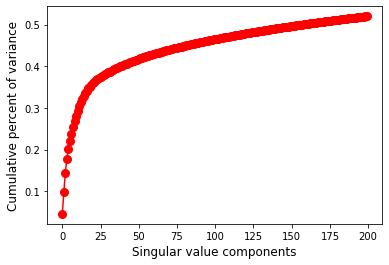

In [98]:
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

## Collaborative Filtering

In [99]:
# text transformation and truncated SVD to create a collaborative
    # latent matrix:
ratings_f1 = pd.merge(movies['movieId'], ratings_f,
                          on="movieId", how="right")
ratings_f2 = ratings_f1.pivot(
                           index='movieId', columns='userId',
                           values='rating').fillna(0)
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(
                             latent_matrix_2,
                             index=Final.title.tolist())

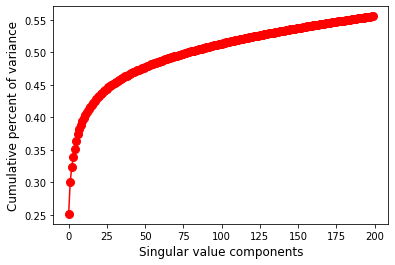

In [100]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

# Surprise

In [101]:
# now a user collabortive model using Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_f1[['userId', 'movieId', 'rating']],
                                reader)
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()

In [102]:
# Train the algorithm on the trainset, and predict ratings for the testset
algorithm.fit(trainset)
accuracy.rmse(algorithm.test(testset))

RMSE: 0.7403


0.7403427823946469

In [103]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc["Toy Story (1995)"]).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
# dictDf = {'collaborative': score_2} 
similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.911259,0.927260,0.919260
"Bug's Life, A (1998)",0.897454,0.875843,0.886648
"Monsters, Inc. (2001)",0.881555,0.853277,0.867416
Ratatouille (2007),0.818596,0.674636,0.746616
Foul Hunting (1947),0.813391,0.109660,0.461525
Finding Nemo (2003),0.806972,0.831372,0.819172
The Fox and the Hound 2 (2006),0.796880,0.177199,0.487040
Ice Age (2002),0.787686,0.721465,0.754575
Lilo & Stitch 2: Stitch has a Glitch (2005),0.778956,0.141095,0.460026
Return to Never Land (2002),0.763521,0.310329,0.536925


In [104]:
similar.sort_values('collaborative', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.911259,0.927260,0.919260
Jurassic Park (1993),0.105146,0.889209,0.497177
Forrest Gump (1994),0.194385,0.886086,0.540236
"Lion King, The (1994)",0.637394,0.881440,0.759417
Men in Black (a.k.a. MIB) (1997),0.067629,0.876443,0.472036
Back to the Future (1985),0.184255,0.876075,0.530165
"Bug's Life, A (1998)",0.897454,0.875843,0.886648
Aladdin (1992),0.680896,0.866900,0.773898
Shrek (2001),0.520674,0.858730,0.689702
"Matrix, The (1999)",0.045911,0.857649,0.451780


In [105]:
similar.sort_values('hybrid', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.911259,0.927260,0.919260
"Bug's Life, A (1998)",0.897454,0.875843,0.886648
"Monsters, Inc. (2001)",0.881555,0.853277,0.867416
Finding Nemo (2003),0.806972,0.831372,0.819172
Aladdin (1992),0.680896,0.866900,0.773898
"Lion King, The (1994)",0.637394,0.881440,0.759417
Ice Age (2002),0.787686,0.721465,0.754575
Ratatouille (2007),0.818596,0.674636,0.746616
Antz (1998),0.689728,0.747463,0.718596
"Incredibles, The (2004)",0.613848,0.801376,0.707612


# Hybrid Recommendation System

In [106]:
def recommend_similar_movies(title):
    # take the latent vectors for a selected movie from both content 
    # and collaborative matrixes
    a_1 = np.array(latent_matrix_1_df.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    # calculate the similartity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # an average measure of both content and collaborative 
    hybrid = ((score_1 + score_2)/2.0)

    # form a data frame of similar movies 
    dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
    similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

    #sort it on the basis of either: content, collaborative or hybrid
    similar.sort_values('hybrid', ascending=False, inplace=True)

    print(similar[1:].head(11))

In [107]:
recommend_similar_movies("Toy Story (1995)")

                             content  collaborative    hybrid
Toy Story 2 (1999)          0.911259       0.927260  0.919260
Bug's Life, A (1998)        0.897454       0.875843  0.886648
Monsters, Inc. (2001)       0.881555       0.853277  0.867416
Finding Nemo (2003)         0.806972       0.831372  0.819172
Aladdin (1992)              0.680896       0.866900  0.773898
Lion King, The (1994)       0.637394       0.881440  0.759417
Ice Age (2002)              0.787686       0.721465  0.754575
Ratatouille (2007)          0.818596       0.674636  0.746616
Antz (1998)                 0.689728       0.747463  0.718596
Incredibles, The (2004)     0.613848       0.801376  0.707612
Little Mermaid, The (1989)  0.658868       0.742400  0.700634


In [108]:
recommend_similar_movies("GoldenEye (1995)")

                                  content  collaborative    hybrid
World Is Not Enough, The (1999)  0.987157       0.879168  0.933163
Tomorrow Never Dies (1997)       0.920224       0.918434  0.919329
Die Another Day (2002)           0.987873       0.763227  0.875550
Goldfinger (1964)                0.980424       0.767273  0.873848
Licence to Kill (1989)           0.988472       0.718103  0.853288
From Russia with Love (1963)     0.987870       0.691428  0.839649
Dr. No (1962)                    0.973874       0.704636  0.839255
Diamonds Are Forever (1971)      0.985429       0.673005  0.829217
For Your Eyes Only (1981)        0.983193       0.673117  0.828155
Live and Let Die (1973)          0.982238       0.669441  0.825839
View to a Kill, A (1985)         0.970500       0.681148  0.825824


In [109]:
recommend_similar_movies("Mission: Impossible (1996)")

                                              content  collaborative    hybrid
Mission: Impossible II (2000)                0.776488       0.876882  0.826685
True Lies (1994)                             0.632633       0.895313  0.763973
Speed (1994)                                 0.565773       0.918202  0.741988
Mission: Impossible III (2006)               0.814847       0.639046  0.726947
Bourne Identity, The (2002)                  0.709292       0.741810  0.725551
Clear and Present Danger (1994)              0.626994       0.767443  0.697219
Bourne Supremacy, The (2004)                 0.694982       0.683977  0.689479
Die Hard: With a Vengeance (1995)            0.510736       0.844092  0.677414
Rock, The (1996)                             0.438919       0.913495  0.676207
Mission: Impossible - Ghost Protocol (2011)  0.834099       0.505689  0.669894
Air Force One (1997)                         0.514770       0.824556  0.669663


# Turicreate

In [20]:
#! pip install turicreate

  Using cached turicreate-6.4.tar.gz (1.9 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for turicreate
Failed to build turicreate
    Running setup.py install for turicreate: started
    Running setup.py install for turicreate: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'c:\users\eduar\anaconda3\envs\pycharmlearningproject\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\eduar\\AppData\\Local\\Temp\\pip-install-q8clgd9r\\turicreate_d613dfda545248ba8fd5fc08e9580bb5\\setup.py'"'"'; __file__='"'"'C:\\Users\\eduar\\AppData\\Local\\Temp\\pip-install-q8clgd9r\\turicreate_d613dfda545248ba8fd5fc08e9580bb5\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\eduar\AppData\Local\Temp\pip-wheel-cwha55j_'
       cwd: C:\Users\eduar\AppData\Local\Temp\pip-install-q8clgd9r\turicreate_d613dfda545248ba8fd5fc08e9580bb5\
  Complete output (31 lines):
  running bdist_wheel
  running build
  installing to build\bdist.win-amd64\w

In [23]:
#!pip install -U pip

In [24]:
#!pip install -U turicreate

  ERROR: Command errored out with exit status 1:
   command: 'c:\users\eduar\anaconda3\envs\pycharmlearningproject\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\eduar\\AppData\\Local\\Temp\\pip-install-6ju_mcy9\\turicreate_c3967cc94ca240a18fef52c7a16c3c33\\setup.py'"'"'; __file__='"'"'C:\\Users\\eduar\\AppData\\Local\\Temp\\pip-install-6ju_mcy9\\turicreate_c3967cc94ca240a18fef52c7a16c3c33\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\eduar\AppData\Local\Temp\pip-wheel-wtks1zm9'
       cwd: C:\Users\eduar\AppData\Local\Temp\pip-install-6ju_mcy9\turicreate_c3967cc94ca240a18fef52c7a16c3c33\
  Complete output (31 lines):
  running bdist_wheel
  running build
  installing to build\bdist.win-amd64\w


  Using cached turicreate-6.4.tar.gz (1.9 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for turicreate
Failed to build turicreate
    Running setup.py install for turicreate: started
    Running setup.py install for turicreate: finished with status 'error'



  
  
  ----------------------------------------
  ERROR: Failed building wheel for turicreate
    ERROR: Command errored out with exit status 1:
     command: 'c:\users\eduar\anaconda3\envs\pycharmlearningproject\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\eduar\\AppData\\Local\\Temp\\pip-install-6ju_mcy9\\turicreate_c3967cc94ca240a18fef52c7a16c3c33\\setup.py'"'"'; __file__='"'"'C:\\Users\\eduar\\AppData\\Local\\Temp\\pip-install-6ju_mcy9\\turicreate_c3967cc94ca240a18fef52c7a16c3c33\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record 'C:\Users\eduar\AppData\Local\Temp\pip-record-nmpq9udk\install-record.txt' --single-version-externally-managed --compile --install-headers 'c:\users\eduar\anaconda3\envs\py

In [22]:
#!python -m pip install --upgrade pip 

In [21]:
#import turicreate

ModuleNotFoundError: No module named 'turicreate'

## I tried to use Turicreate but I could not make it work correctly in my local computer. So as it is not required for this assignment I gave up on it for now

In [ ]:
#I tried to use Turicreate but I could not make it work correctly in my local computer. So as it is not required for this assignment I gave up on it.

# Matrix Factorization

In [10]:
class MF():
    
    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing user-feature and movie-feature matrix 
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [11]:
    # filters the number of movies we can keep-- the reason is my laptop limited power.
ratings_for_matrix = ratings.groupby('userId').filter(lambda x: len(x) >= 500)
movie_list_rating2 = ratings_for_matrix.movieId.unique().tolist()

print('This code keeps',round(len(ratings_for_matrix.movieId.unique())/len(movies.movieId.unique()) * 100,2),'%','of the original movie titles, using only ',
      round(len(ratings_for_matrix.userId.unique())/len(ratings.userId.unique()) * 100,2),'%',
      'of the users. This allows me to get a very good accuracy without compromise performance')

This code keeps 92.26 % of the original movie titles, using only  5.98 % of the users. This allows me to get a very good accuracy without compromise performance


In [12]:
R= np.array(ratings_for_matrix.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0))

In [13]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

# Conclusions

## The model works pretty well, delivering very good movie recommendations with high accuracy. I am very satisfied with this model results, even though I have filtered data from it. 